<div class="alert alert-success" style = "border-radius:5px;text-align: center; color: white; background-color: black" role="alert">
    Detailed data exploratory analysis on Duolingo's student trace! Please upvote if you liked the notebook!
</div>

**Context**: [Duolingo](https://www.duolingo.com/) is an American educational technology company that produces learning apps and provides language certification. There main app is considered the most popular language learning app in the world.

To progress in their learning journey, each user of the application needs to complete a set of lessons in which they are presented with the words of the language they want to learn. In an infinite set of lessons, each word is applied in a different context and, on top of that, Duolingo uses a spaced repetition approach, where the user sees an already known word again to reinforce their learning.

Each line in this file refers to a Duolingo lesson that had a target word to practice. This notebook aims to explore the content of [Duolingo Dataset](https://www.kaggle.com/datasets/aravinii/duolingo-spaced-repetition-data), a file containing 13 million Duolingo student learning traces.

For the sake of curiosity, the main questions we will try to cover in this analysis are:

* Basic information (total users, total lerned languages, total words learned, correct practices rate)
* Most frequently learned languages
* Most difficult languages learned by english speakers
* What are the most challenging grammatical parts
* Strategies for Duolingo app usage growth
* Consecutive days engagement
* Deep diving into days usage behavior
* Does the time since the last practice imply a greater probability of failure?

# Importing libs and reading the dataset

In [1]:
!pip install lifelines

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 4.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=6fcaa801e458f4aeaa62b8787e70f8699e8508f0658aa5bbed00cbb745c36b93
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from sklearn.preprocessing import PowerTransformer
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
pt = PowerTransformer(method='box-cox')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df = pd.read_csv(dirname + '/' + filenames[0])

/kaggle/input/duolingo-spaced-repetition-data/learning_traces.13m.csv


# Basic information about the dataset

We have 12 columns in the dataset, as it follows:

- Two of them are identifiers (for user and for the practiced word) and other one is the timestamp indicating when the practice happened. 
- We have the indication of the learning language and of the interface language (presumably native to the student).
- We also have the word practiced with some gramatical details as the inflected and the uninflected form seen in (or intended for) the exercise, the part of speech and each of the modifers (tense, gender, person, case, etc.).
- Finally, we have some numerical stuff as the total times user has seen the word, total times user has been correct for the word, times the user saw the word during the specific lesson, times the user got the word correct during this specific lesson and the time (in seconds) since the last lesson that included this word.

In [3]:
df.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1
4,1.0,1362076081,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,1,1


#### Dimensions of our dataset...

In [4]:
shape = df.shape
print('The number of lines presented in this dataset are {}'.format(shape[0]))
print('The number of columns presented in this dataset are {}'.format(shape[1]))

The number of lines presented in this dataset are 12854226
The number of columns presented in this dataset are 12


#### The datatypes of each column of our dataset... 

All of them are correct, except for the timestamp feature that we will cast from unix to a readable datetime format.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12854226 entries, 0 to 12854225
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   p_recall           float64
 1   timestamp          int64  
 2   delta              int64  
 3   user_id            object 
 4   learning_language  object 
 5   ui_language        object 
 6   lexeme_id          object 
 7   lexeme_string      object 
 8   history_seen       int64  
 9   history_correct    int64  
 10  session_seen       int64  
 11  session_correct    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 1.1+ GB


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')

#### Checking for null values (there is no null value in this dataset)...

In [7]:
df.isnull().sum()

p_recall             0
timestamp            0
delta                0
user_id              0
learning_language    0
ui_language          0
lexeme_id            0
lexeme_string        0
history_seen         0
history_correct      0
session_seen         0
session_correct      0
dtype: int64

#### Finding duplicated values...

In [8]:
print('We find {} duplicated values. The solution is to drop it.'.format(df.duplicated().sum()))

We find 81 duplicated values. The solution is to drop it.


In [9]:
df.drop_duplicates(inplace=True)

#### Undestanding the numeric values...

There are some outliers for history and for delta columns, we will explore this variables later in this notebook.

In [10]:
df[['p_recall', 'delta', 'history_seen', 'history_correct', 'session_seen', 'session_correct']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,p_recall,delta,history_seen,history_correct,session_seen,session_correct
count,12854145.00000,12854145.00000,12854145.00000,12854145.00000,12854145.00000,12854145.00000
mean,0.89611,729581.07669,21.98107,19.35027,1.81769,1.64414
std,0.27140,2246504.15116,129.55119,111.96842,1.36018,1.31880
min,0.00000,1.00000,1.00000,1.00000,1.00000,0.00000
25%,1.00000,532.00000,3.00000,3.00000,1.00000,1.00000
50%,1.00000,77134.00000,6.00000,6.00000,1.00000,1.00000
75%,1.00000,442503.00000,15.00000,13.00000,2.00000,2.00000
max,1.00000,40328362.00000,13518.00000,12888.00000,20.00000,20.00000


#### Unique dimensions...

In [11]:
print('We have {} unique users learning {} different lexemes.'.format(df.user_id.nunique(), df.lexeme_id.nunique()))

We have 115222 unique users learning 19279 different lexemes.


#### Period analyzed...

In [12]:
aux = df['timestamp'].agg(['min', 'max'])
print('We will be analysing data from {} to {}.'.format(aux.iloc[0], aux.iloc[1]))

We will be analysing data from 2013-02-28 18:28:01 to 2013-03-12 16:14:57.


#### General correct rate...

In [13]:
print('The general correct rate of the dataset is {:.2f}%.'.format(100*df['session_correct'].sum()/df['session_seen'].sum()))

The general correct rate of the dataset is 90.45%.


Since Duolingo encourages its users to achieve a perfect practice mark, we can also look at a perfection rate...

In [14]:
df['session_perfect'] = (df['session_correct'] == df['session_seen'])
print('The general perfection rate of the dataset is {:.2f}%.'.format(100*df['session_perfect'].sum()/df['session_perfect'].count()))

The general perfection rate of the dataset is 83.89%.


# Most frequently learned languages

This dataset is obviously a sample of something much bigger, but this might at least give us a dimension of the magnitude of each language mentioned. In this section, English seems to be the most practiced language and Portuguese the least practiced.

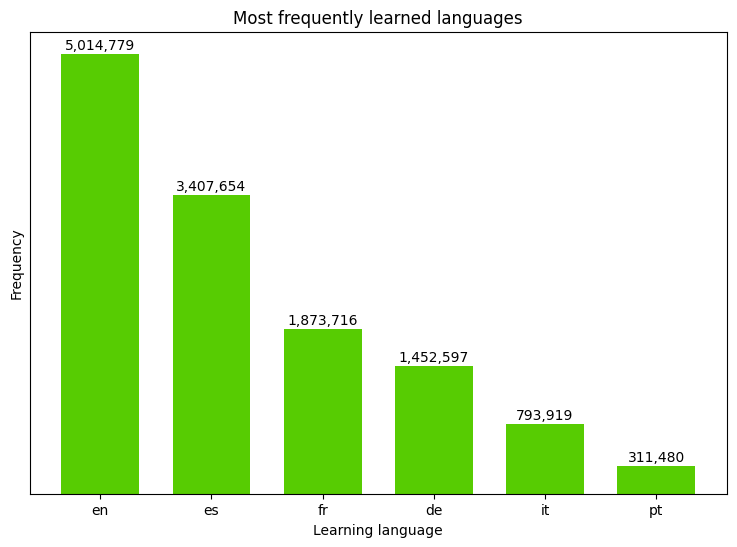

In [15]:
plt.figure(figsize=(9,6))

#Plotting the grouped dataframe with necessary fields for the chart
bar_plot = pd.DataFrame(df['learning_language'].value_counts()).reset_index()
xis = [i for i in range(bar_plot['learning_language'].nunique())]
x1 = plt.bar(xis, bar_plot['count'], width = 0.7, color = '#57cc02')

#Better allocating the values shown in the bars
for i in range(len(xis)):
    if bar_plot['count'].iloc[i] > 999999:
        plt.text(x=xis[i]-0.32, y=bar_plot['count'].iloc[i]+55000, s='{:,}'.format(bar_plot['count'].iloc[i]), size=10)
    else:
        plt.text(x=xis[i]-0.26, y=bar_plot['count'].iloc[i]+55000, s='{:,}'.format(bar_plot['count'].iloc[i]), size=10)

#Fancy stuff
plt.title('Most frequently learned languages')
plt.yticks([])
plt.xticks(xis, bar_plot['learning_language'].unique())
plt.ylabel('Frequency')
plt.xlabel('Learning language')
plt.show()

# Most difficult languages learned by english speakers

Focusing on the app's largest audience (english speakers), it may be interesting to understand which language is most difficult for them to learn...

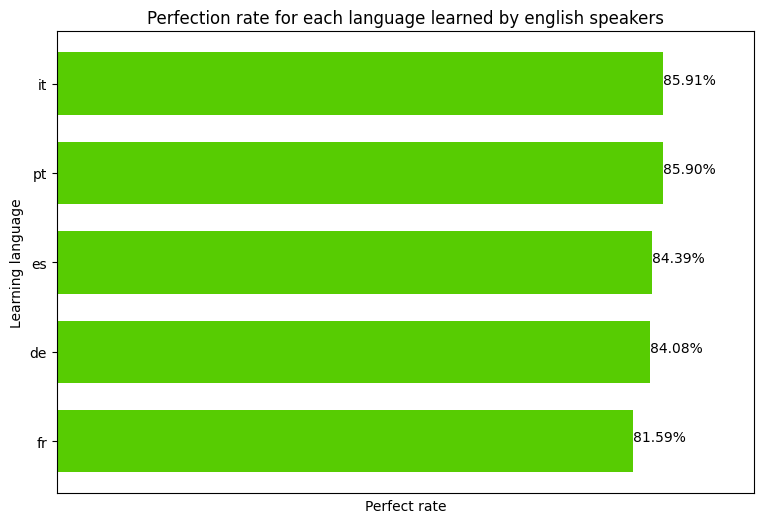

In [16]:
plt.figure(figsize=(9,6))

#Plotting the grouped dataframe with necessary fields for the chart
bar_plot = df[df['ui_language']=='en'][['learning_language', 'session_perfect']].copy()
bar_plot = bar_plot.groupby(by=['learning_language']).agg(['sum', 'count']).reset_index()
bar_plot.columns = ['learning_language', 'sum', 'count']
bar_plot['perfection_rate'] = bar_plot['sum']/bar_plot['count']
bar_plot.sort_values(by=['perfection_rate'], ascending=True, inplace=True)
xis = [i for i in range(bar_plot['learning_language'].nunique())]
x1 = plt.barh(xis, bar_plot['perfection_rate'], color = '#57cc02', label='correct percent', height=0.7)

#Better allocating the values shown in the bars
for i in range(len(xis)):
    plt.text(y=xis[i], x=bar_plot['perfection_rate'].iloc[i], s='{:.2f}'.format(100*bar_plot['perfection_rate'].iloc[i])+'%', size=10)

#Fancy stuff
plt.xticks([])
plt.title('Perfection rate for each language learned by english speakers')
plt.yticks(xis, bar_plot['learning_language'].unique())
plt.margins(x=.15)
plt.xlabel('Perfect rate')
plt.ylabel('Learning language')
plt.show()

As a Portuguese speaker, I can say that I am surprised to see that my language seems to be one of the easiest for English speakers to learn. We have several very particular sounds in the language and a very complex multitude of ways to conjugate a verb. On the other hand, French, despite also being a language derived from Latin, is definitely a difficult language to learn, I completely agree with English speakers!

# Most challenging grammatical parts

To explore the grammatical parts we had to do some feature engineering to extract the indexed information through some codes...

In [17]:
aux_list = list()
for part in df['lexeme_string'].values:
    if 'prn>' in part:
        aux_list.append('pronoun')
    elif 'n>' in part:
        aux_list.append('noun')
    elif 'det>' in part:
        aux_list.append('determinative')
    elif 'adj>' in part:
        aux_list.append('adjective')
    elif 'adv>' in part:
        aux_list.append('adverb')
    elif '<vb' in part:
        aux_list.append('verb')
    elif 'ij>' in part:
        aux_list.append('interjection')
    elif 'pr>' in part:
        aux_list.append('preposition')
    elif 'cnjcoo>' in part:
        aux_list.append('conjunction')
    elif 'num>' in part:
        aux_list.append('number')
    else:
        aux_list.append('n/a')
        
df['gramatical_part'] = aux_list

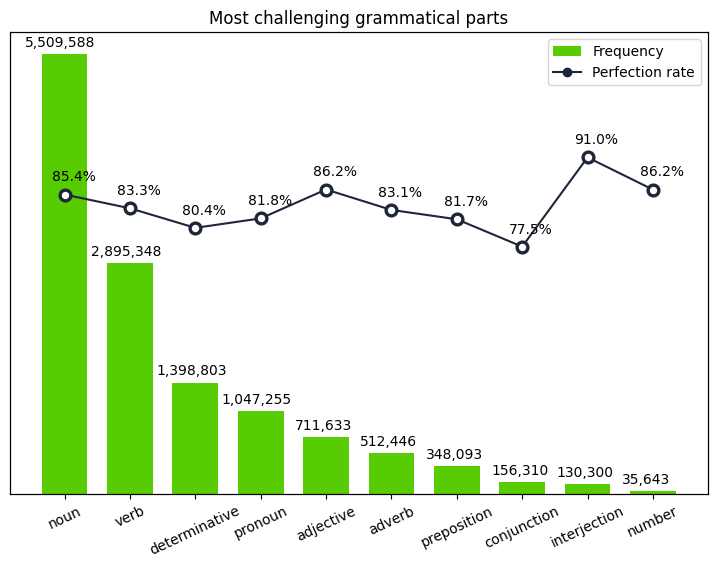

In [18]:
fig, x1 = plt.subplots(figsize=(9,6))

#Defining the grouped dataframe with necessary fields for the chart
bar_plot = df[df['gramatical_part']!='n/a'][['gramatical_part', 'session_perfect']].copy()
bar_plot = bar_plot.groupby(by=['gramatical_part']).agg(['sum', 'count']).reset_index()
bar_plot.columns = ['gramatical_part', 'sum', 'count']
bar_plot['perfection_rate'] = bar_plot['sum']/bar_plot['count']
bar_plot.sort_values(by=['count'], ascending=False, inplace=True)

#Plotting bars and lines
xis = [i for i in range(bar_plot['gramatical_part'].nunique())]
x1.bar(xis, bar_plot['count'], color = '#57cc02', label='Frequency', width=0.7)
x2 = x1.twinx()
x2.plot(xis, bar_plot['perfection_rate'], color = '#1e263a', label='Perfection rate', marker='o')
x2.scatter(xis, bar_plot['perfection_rate'], fc="w", ec="#1e263a", s=60, lw=2.4, zorder=12) 

#Better allocating the values shown in the bars and the lines
for i in range(len(xis)):
    y_value = bar_plot['perfection_rate'].iloc[i]
    y_other_value = bar_plot['count'].iloc[i]
    x2.text(x=xis[i]-0.2, y=y_value+0.02, s='{:.1f}'.format(100*y_value)+'%', size=10)
    if bar_plot['count'].iloc[i] > 999999:
        x1.text(x=xis[i]-0.6, y=y_other_value+90000, s='{:,}'.format(y_other_value), size=10)
    else:
        x1.text(x=xis[i]-0.475, y=y_other_value+90000, s='{:,}'.format(y_other_value), size=10)

#Fancy stuff
x1.set_yticks([])
x2.set_yticks([])
x2.set_ylim([0.40,1.1])
plt.title('Most challenging grammatical parts')
x1.set_xticks(xis, bar_plot['gramatical_part'].unique(), rotation=25)
lines_1, labels_1 = x1.get_legend_handles_labels()
lines_2, labels_2 = x2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
plt.legend(lines, labels, loc=0)
plt.show()

Many interesting things to analyze with the graph above. First, nouns and verbs are the most frequent grammatical parts while interjections and numbers are the least. The difference between the frequency of practice with the two terms is enormous, users practice 154 times more nouns than numbers. The hardest part for users to learn are conjunctions (as although, though and whereas) and the easiest part is interjections (like every sound we express in words). I'm not surprised, in fact conjunctions are very difficult to learn in a new language.

# Strategies for duolingo app usage growth

Here we also had to apply feature engineering to adapt the way we would display information when users generally use the app...

In [19]:
aux = {4:1, 5:2, 6:3, 7:4, 8:5, 9:6, 10:7, 11:8, 12:9, 13:10, 14:11, 15:12, 16:13, 17:14, 18:15, 19:16, 20:17, 21:18, 22:19, 23:20, 24:21, 1:22, 2:23, 3:24}
df['hour'] = df['timestamp'].dt.hour
df['hour_aux'] = df['hour'].map(aux)
color = ['#ffde01ff','#ffde01ff','#ffde01ff','#ffde01ff','#ffde01ff',
         '#00c3ffff','#00c3ffff','#00c3ffff','#00c3ffff','#00c3ffff','#00c3ffff',
         '#57cc02','#57cc02','#57cc02','#57cc02','#57cc02','#57cc02','#57cc02',
         '#ff4c4bff','#ff4c4bff','#ff4c4bff','#ff4c4bff','#ff4c4bff'
        ]

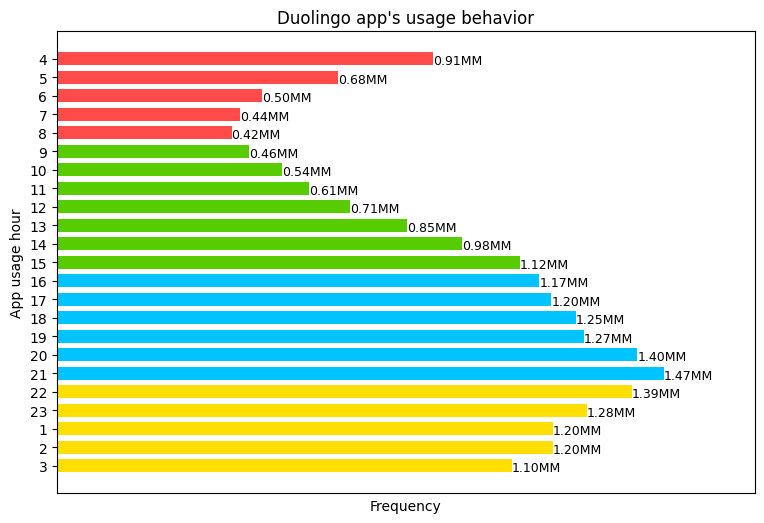

In [20]:
plt.figure(figsize=(9,6))

#Plotting the grouped dataframe with necessary fields for the chart
bar_plot = df[['hour','hour_aux', 'session_seen']].groupby(by=['hour', 'hour_aux']).sum().reset_index()
bar_plot.sort_values(by=['hour_aux'], ascending=False, inplace=True)
xis = [i for i in range(bar_plot['hour'].nunique())]
x1 = plt.barh(xis, bar_plot['session_seen'], color = color, label='sessions seen', height=0.7)

#Better allocating the values shown in the bars
for i in range(len(xis)):
    x_value = bar_plot['session_seen'].iloc[i]
    plt.text(y=xis[i]-0.3, x=x_value, s='{:.2f}MM'.format((x_value)/1000000), size=9)

#Fancy stuff
plt.xticks([])
plt.title("Duolingo app's usage behavior")
plt.yticks(xis, bar_plot['hour'].unique())
plt.margins(x=.15)
plt.ylabel('App usage hour')
plt.xlabel('Frequency')
plt.show()

One thing that came to mind when I was building this analysis was trying to understand at what time of day users use the application most. 

If you don't know their teaching approach, let me summarize: Duolingo applies a cool and gamified way to encourage users to always continue their learning journey on the app. One of the strategies they use are the "Missions". Basically, they are challenges that try to attack the main moments that could cause users to lose engagement. The idea is that if I can force you to wake up at 7 am to practice and you receive a reward for that effort, you will probably want to maintain this habit in the future.

I will separate the users' daily journey into four major moments:

* Critical (4am - 8am)

Users here are very little engaged, I recommend that we think about **urgent strategies to reactivate** this period.

* Growing slowly (9am-3pm)

We see an improvement in behavior, but we still need to **further accelerate** these users who are resuming their routine.

* More engaged (4pm-9pm)

These are the best and most engaged moments for users. We **don't need to put any effort here**. We want all users to reach this level of use.

* Losing interest (10pm-3am)

Users are currently starting to disengage, despite still showing a good level of usage. I recommend thinking about **strategies for maintaining dedication**.

# Consecutive days engagement

Once again we applied a bit of feature engineering to extract new information such as the sequence of days in which the user used the app at least once...

In [21]:
df['date'] = df['timestamp'].dt.date
df.sort_values(by=['user_id', 'date'], ascending=False, inplace=True)
df_aux = df[['user_id', 'date']].drop_duplicates()
df_aux['sequence_end'] = ~(df_aux['date'] + timedelta(days=1) == df_aux.groupby(['user_id'])['date'].shift(1))
df_aux['sequence_start'] = ~(df_aux['date'] - timedelta(days=1) == df_aux.groupby(['user_id'])['date'].shift(-1))

df_aux_2 = df_aux[df_aux['sequence_start']==True][['user_id', 'date']].reset_index(drop=True)
df_aux_2.columns = ['user_id', 'sequence_start'] 
df_aux_2['sequence_end'] = df_aux[df_aux['sequence_end']==True].reset_index()['date']
df_aux_2[['sequence_start', 'sequence_end']] = df_aux_2[['sequence_start', 'sequence_end']].apply(pd.to_datetime)
df_aux_2['sequence_length'] = (df_aux_2['sequence_end'] - df_aux_2['sequence_start']).dt.days + 1
df_aux_2.sort_values(by=['sequence_length'], inplace=True, ascending=False)

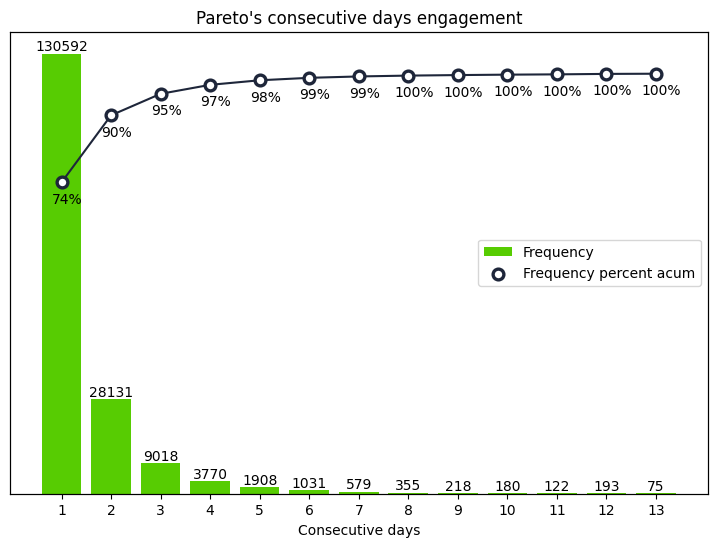

In [22]:
fig, ax = plt.subplots(figsize=(9,6))

#Defining the grouped dataframe with necessary fields for the chart
df_group = df_aux_2[['sequence_length', 'user_id']].groupby(by=['sequence_length']).count().reset_index()
df_group['cum_sum'] = df_group['user_id'].cumsum()
df_group['percent'] = df_group['cum_sum'] / df_group['user_id'].sum() * 100

#Plotting bars and lines
line0 = ax.bar(df_group['sequence_length'], df_group['user_id'], color="#57cc02", label='Frequency')
ax.set_title("Pareto's consecutive days engagement")
plt.xlabel('Consecutive days')
ax2 = ax.twinx()
line1 = ax2.plot(df_group['sequence_length'], df_group['percent'], color="#1e263a", ms=7, marker='o')
ax2.scatter(df_group['sequence_length'], df_group['percent'], 
            fc="w", ec="#1e263a", s=60, lw=2.4, zorder=12, label='Frequency percent acum') 

#Better allocating the values shown in the bars
rects = ax.patches
labels = df_group['sequence_length']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, height, ha="center", va="bottom"
    )

#Better allocating the values shown in the lines
line = ax2.lines[0]
for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
    label = "{:.0f}%".format(y_value)
    ax2.annotate(label,(x_value, y_value), xytext=(4, -15), 
        textcoords="offset points", ha='center')

#Fancy stuff
plt.xticks(df_group['sequence_length'])
ax.set_yticks([])
ax2.set_yticks([])
ax2.set_ylim([0,110])
plt.yticks([])
line0, label0 = ax.get_legend_handles_labels()
line1, label1 = ax2.get_legend_handles_labels()
lines = line0 + line1
labels = label0 + label1
plt.legend(lines, labels, loc='center right')
plt.show()

A curious fact about our database is that 74% of the sequences only last a single day. These are users who are getting used to or who do not yet have a continued commitment to the methodology. On the other hand, 75 users had a perfect sequence, practicing on every day analyzed in the sample.

Duolingo usually rewards users with great streaks like the 365 straight days of practicing that I recently achieved. On this occasion, users usually receive customizations in the app icon or badges that highlight to the community that the user is doing well!

To recover users with interrupted sequences, Duolingo sometimes gives the opportunity to restore the sequence. Investing more in these strategies, as well as in push notifications to call these users back to the app, can help encourage greater sequences.

# Deep diving into days usage behavior

It could also be interesting to analyze when users prefer to practice. Would the weekend with free time be the ideal time or would a getaway during the busy week be the most common time?

In [23]:
df_aux = df[['user_id', 'date', 'timestamp']].groupby(by=['user_id', 'date']).nunique().reset_index()
df_aux.columns = ['user_id', 'date', 'count_lessons']
df_aux = df_aux[['date', 'count_lessons']].groupby(by='date').sum().reset_index()
df_aux.columns = ['date', 'count_lessons']

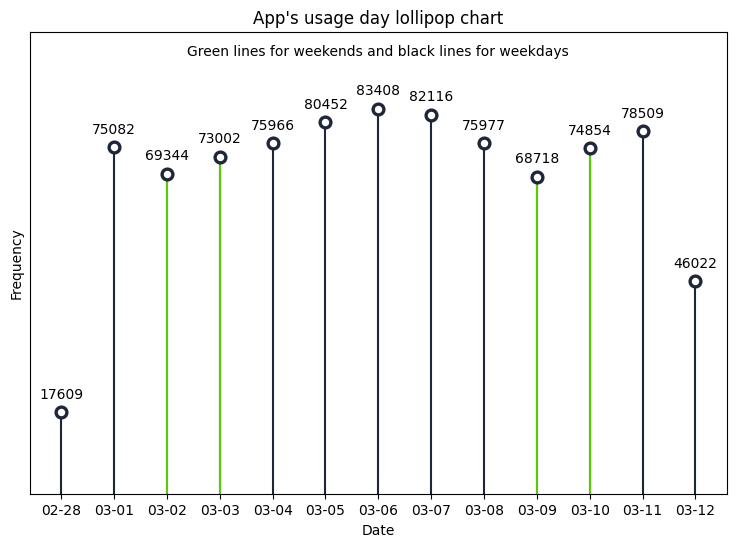

In [24]:
fig, ax = plt.subplots(figsize = (9, 6))

#Defining the grouped dataframe with necessary fields for the chart
x = df_aux['date']
y = df_aux['count_lessons']
ax.vlines(x, ymin=0, ymax=y, color='#1e263a')
ax.scatter(x, y, fc="w", ec="#1e263a", s=60, lw=2.4, zorder=12, label='ddd')
ax.plot(x,y, "o", color='#1e263a')

#Better allocating the values shown in the lines
line = ax.lines[0]
for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
    label = y_value
    ax.annotate(label,(x_value, y_value), xytext=(0, 10), 
        textcoords="offset points", ha='center')
    if x_value.weekday() in (5,6):
        plt.vlines(x_value, ymin=0, ymax=y_value, color='#57cc02')

#Fancy stuff
ax.annotate('Green lines for weekends and black lines for weekdays', xy=(x[6], 95000), ha='center')
ax.set_xticks(x)
ax.set_xticklabels([str(value)[5:] for value in x])
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylim([0,df_aux['count_lessons'].max()*1.2])
ax.set_ylabel("Frequency")
ax.set_xlabel("Date")
ax.set_title("App's usage day lollipop chart")
plt.show()

It seems that March 6th was the day that users practiced the most. Furthermore, the tendency is for users to practice more on weekdays days than on weekends.

# How much they practice a day?

Continuing to delve deeper into customer behavior analysis, we discovered that French is the only language in which customers practice a little less than other languages.

Coincidence or not, it is also the most difficult language to learn, as we saw previously in this notebook. To give you an idea, most users practice 1 to 4 times a day in most languages, while in French this number drops to 1 to 3.

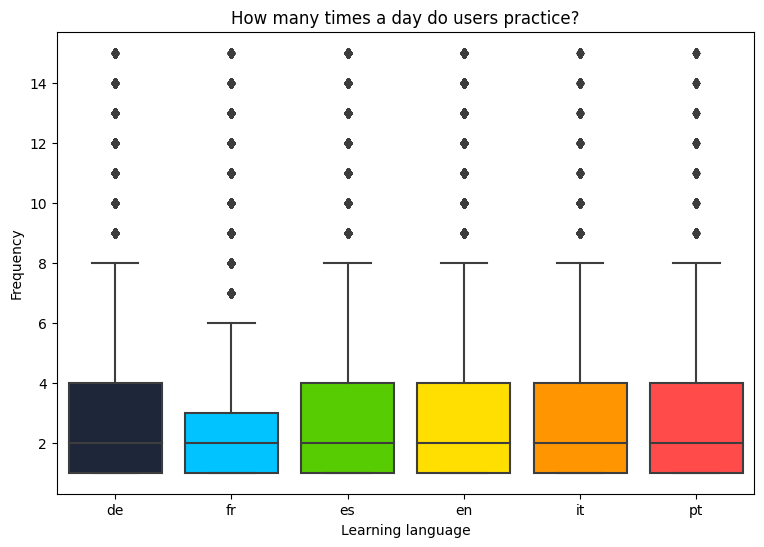

In [25]:
plt.figure(figsize=(9,6))

#Defining the grouped dataframe with necessary fields for the chart
df_aux = df[['user_id', 'learning_language', 'date', 'timestamp']].groupby(by=['user_id', 'learning_language', 'date']).nunique().reset_index()
df_aux.columns = ['user_id', 'learning_language', 'date', 'count_lessons']
df_aux = df_aux[df_aux['count_lessons'] <= df_aux['count_lessons'].quantile(0.975)].copy()
ax = sns.boxplot(x='learning_language', y='count_lessons', data=df_aux)

#Fancy stuff
colors = ['#1e263a', '#00c3ffff', '#57cc02', '#ffde01ff', '#ff9601ff', '#ff4c4bff']
for patch, color in zip(ax.patches, colors):
    patch.set_facecolor(color)
plt.title("How many times a day do users practice?")
plt.ylabel('Frequency')
plt.xlabel('Learning language')
plt.show()

# Does the time since the last practice imply a greater probability of a mistake?

With the survival analysis below, we can see that the longer the period since the last time a given lexeme was practiced, the greater the chance that in the next attempt there will be at least one mistake (imperfect session). Furthermore, this probability drops even further if the last practice session had no errors (perfect session).

This suggests that perhaps if a user has a perfect session today, they might let their guard down for the next time they practice. On the other hand, if the user makes an error, perhaps he will be more attentive so that he does not make mistakes again on the next attempt.

In [26]:
#Preparing the database to apply the model
df_aux = df[['user_id', 'lexeme_id', 'session_perfect', 'timestamp']].drop_duplicates()
df_aux.sort_values(by=['user_id', 'timestamp'], ascending=[True,False], inplace=True)
df_aux['previous_session_perfect'] = df_aux.groupby(['user_id', 'lexeme_id'])['session_perfect'].shift(-1)
df_aux['previous_timestamp'] = df_aux.groupby(['user_id', 'lexeme_id'])['timestamp'].shift(-1)
df_aux = df_aux[df_aux['previous_session_perfect'].notna()]
df_aux['diff_hour'] = np.round((df_aux['timestamp']-df_aux['previous_timestamp'])/np.timedelta64(1, 'h')).astype(int)

#Applying Kaplan Meier model for survival analysis
kmf_prev_perf = KaplanMeierFitter()
kmf_prev_miss = KaplanMeierFitter()
df_aux_ = df_aux[df_aux['previous_session_perfect']==True]
kmf_prev_perf.fit(durations = df_aux_['diff_hour'], event_observed = df_aux_['session_perfect'], 
                  label='Perfect previous session')
df_aux_ = df_aux[df_aux['previous_session_perfect']==False]
kmf_prev_miss.fit(durations = df_aux_['diff_hour'], event_observed = df_aux_['session_perfect'], 
                  label='Imperfect previous session')

<lifelines.KaplanMeierFitter:"Imperfect previous session", fitted with 1.15716e+06 total observations, 273535 right-censored observations>

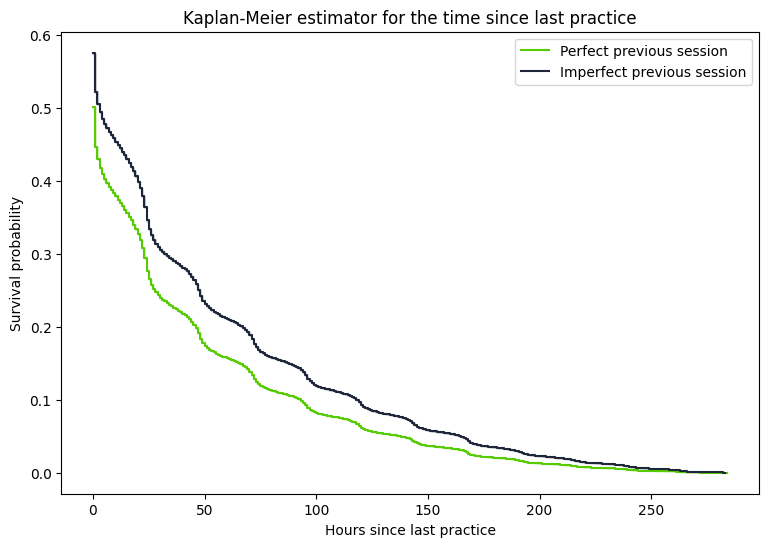

In [27]:
plt.figure(figsize=(9,6))

#Plotting the charts
kmf_prev_perf.plot(color='#57cc02') 
kmf_prev_miss.plot(color='#1e263a') 

#Fancy stuff
plt.title("Kaplan-Meier estimator for the time since last practice") 
plt.xlabel("Hours since last practice") 
plt.ylabel("Survival probability")
plt.show()

In [28]:
print('The median survival time when the last practice was perfect is {}'.format(kmf_prev_perf.median_survival_time_))
print('The median survival time when the last practice was imperfect is {}'.format(kmf_prev_miss.median_survival_time_))

The median survival time when the last practice was perfect is 1.0
The median survival time when the last practice was imperfect is 3.0


Ensuring that the statistical properties provide evidence that we can continue with the analysis. As we have a very small p-value, we can continue with the conclusions presented.

In [29]:
result = logrank_test(df_aux[df_aux['previous_session_perfect']==True]['diff_hour'], 
                         df_aux[df_aux['previous_session_perfect']==False]['diff_hour'], 
                         df_aux[df_aux['previous_session_perfect']==True]['session_perfect'],
                         df_aux[df_aux['previous_session_perfect']==False]['session_perfect'])
result.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
       24557.25 <0.005       inf

# Conclusions

Considering this section of the database, I would suggest:

* Develop new marketing campaigns to encourage the learning of less frequent languages such as Portuguese, Italian or German.

* Discover a way to make learning French a little more intuitive and didactic.

* The number of exercises on grammatical conjunctions would increase to strengthen users' learning in this part.

* Focus on strategies to improve user attendance in the “Critical” and “Growing Slowly” periods.

* I would invest in strategies to restore users' daily sequences and would also increase the number of notifications in the app to call users back to the app.

* If weekdays are more common practice days, I would add a participation bonus on weekends.

* If 1-4 are users' most common frequencies per day, I would create rewards that encourage users to practice at least 5 times or more.

* When we repeat a word already seen, I would create visual alerts for the user to force them to remember that this is a repetition and would even indicate whether or not they got this word right the last time they practiced it. So, we would encourage him to keep getting it right.